In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as ss


In [12]:

import pandas_datareader as web
def get_data(tickers,years):
    year=years*dt.timedelta(days=365)
    end=dt.date.today()
    start=end-year
    data=web.get_data_yahoo(tickers,start,end,interval="m")["Adj Close"]
    returns=data.pct_change()
    return returns,returns.cov()

In [13]:
tickers=["ADANIPORTS.NS","ITC.NS","LT.NS"]
returns,volatility=get_data(tickers,3)
returns.dropna(inplace=True)
returns.head(10)

Symbols,ADANIPORTS.NS,ITC.NS,LT.NS
Date,,,
2019-12-31,0.009290,-0.010728,0.054768
2020-01-31,-0.073633,-0.159898,-0.132732
2020-02-29,-0.265634,-0.130853,-0.319187
2020-03-31,0.167155,0.060280,0.125689
2020-04-30,0.116167,0.084043,0.038661
2020-05-31,0.062075,-0.013681,0.012229
2020-06-30,-0.083454,-0.002569,-0.032003
2020-07-31,0.128648,0.034901,0.034485
2020-08-31,-0.039354,-0.101518,-0.037545


In [14]:
returns.shape

(36, 3)

In [104]:
weights=np.array([1/len(tickers)]*len(tickers))
def portfolio_returns(returns,weights):
    return np.sum(returns*weights,axis=1)
def portfolio_volatility(volatility,weights):
    return (weights @ volatility @ weights.T)**0.5

In [253]:
portfolio_rets=portfolio_returns(returns,weights)
portfolio_vol=portfolio_volatility(volatility,weights)


<h2> Value At Risk (VaR)
<h3> Historic VaR

In [116]:
def hvar(returns,alpha):
    return -np.percentile(returns,alpha)

In [117]:
historical_var=hvar(portfolio_rets,5)
historical_var

0.07512589237703331

<H3>Parametric VaR

In [118]:
def parametric_var(returns,alpha):
    z=ss.norm.ppf(alpha/100)
    return -(returns.mean()+z*returns.std())

In [119]:
parametric_var(portfolio_rets,5)

0.10592959217827055

<H3>Cornish-Fisher VaR

In [120]:
def skewness(returns):
    one=returns-returns.mean()
    two=returns.std()
    three=(one**3).mean()
    return three/two**3

In [121]:
def kurtosis(returns):
    one=returns-returns.mean()
    two=returns.std()
    three=(one**4).mean()
    return three/two**4
    

c:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

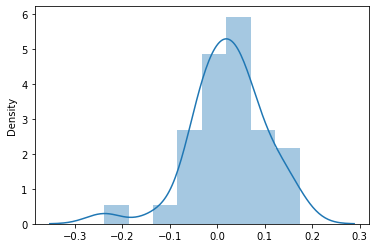

In [124]:
sns.distplot(portfolio_rets)

In [125]:
skewness(portfolio_rets)

-0.7512259601441368

In [126]:
kurtosis(portfolio_rets)

4.792682492953239

In [127]:
def cornishfisher_var(returns,alpha):
    k=kurtosis(returns)
    s=skewness(returns)
    z=ss.norm.ppf(alpha/100)
    w=(z +
            (z**2 - 1)*s/6 +
            (z**3 -3*z)*(k-3)/24 -
            (2*z**3 - 5*z)*(s**2)/36
            )
    return -(returns.mean()+w*returns.std())


In [128]:
cornishfisher_var(portfolio_rets,5)

0.11894483464071254

<h3>Monte Carlo VaR using the Geometric Brownian Motion(gbm) nature of asset prices

In [232]:

def gbm(mu,sigma,n_years,steps_per_year=12,s_0=1000,n_scenarios=5000,prices=True):
    dt=1/steps_per_year
    n_steps=n_years*steps_per_year
    rets=np.random.normal(loc=(1+mu)**dt,scale=(sigma*np.sqrt(dt)),size=(n_steps,n_scenarios))
    rets[0]=1
    return_values=s_0*pd.DataFrame(rets).cumprod() if prices else rets-1


    return return_values


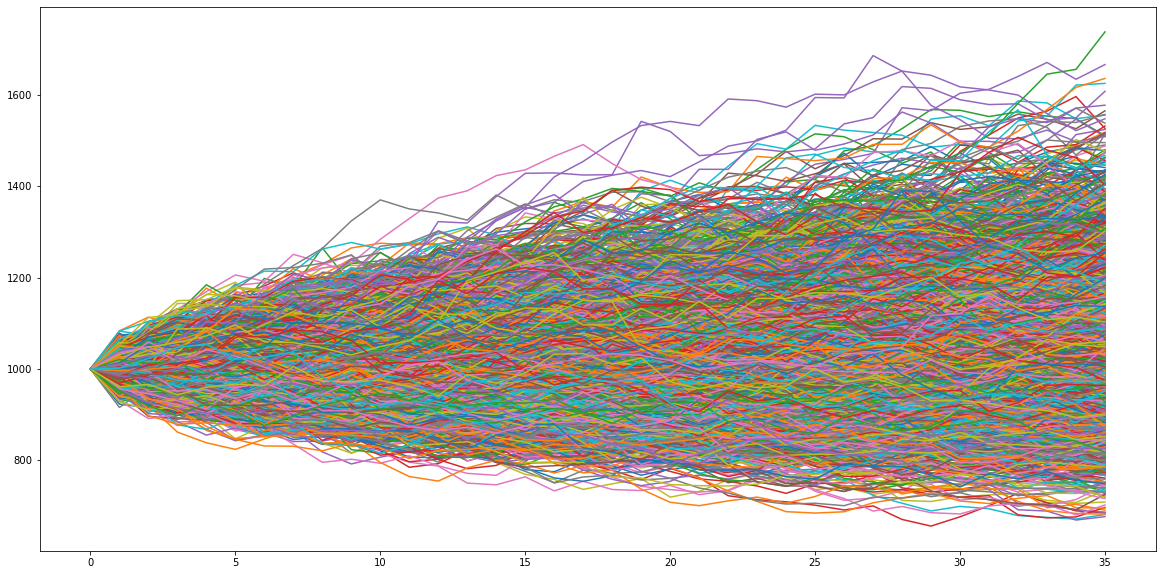

In [233]:
mu=portfolio_rets.mean()
sigma=portfolio_vol
n_years=3
fig,ax=plt.subplots(figsize=(20,10))
ax.plot(gbm(mu,sigma,n_years))
plt.show()


<h3>Distribution of returns calculated using monte-carlo simulations

c:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


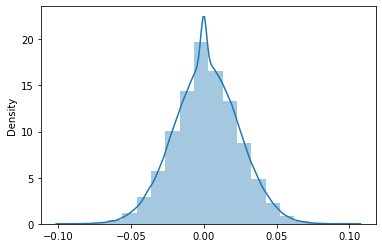

In [254]:
sns.distplot(gbm(mu,sigma,n_years,prices=False),bins=20)
plt.show()

In [255]:
hvar(gbm(mu,sigma,n_years,prices=False),5)

0.034899955837393505